In [1]:
using Plots

# Parameters

γ = 1.66 # Adiabatic index for relativistic gas 5/3 , 4/3 , 1.999
c = 1.0  # Speed of light (set to 1 for simplicity)
N = 250  # Number of grid points
L = 1.0  # Domain length
L_mid = L / 2

N_mid = N / 2
dx = L / N  # Grid spacing
dt = 0.001  # Time step
T = 0.25  # Total simulation time
CFL = 0.9;  # CFL condition
println(L_mid)
println(N_mid)

0.5
125.0


## Initial Conditions

In [2]:
# Initial condition 
function initial_condition(x)
    if x < L_mid
        ρ =  10.0  # Rest-mass density on the left  1.0, 10.0,2.0
        v =  0.0  # Velocity on the left
        p =  40.0/3  # Pressure on the left   1.0, 40.0/3 ,1990
    else
        ρ =  1.0  # Rest-mass density on the right 1.0,0.125,1.0
        v =  0.0    # Velocity on the right
        p =  (2/3)*(10^-6)   # Pressure on the right 0.00001*(2/3) , 0.1 , 995
    end
    W = 1 / sqrt(1 - v^2)  # Lorentz factor
    h = 1 + (γ * p) / ((γ - 1) * ρ)  # Specific enthalpy
    
    D = ρ * W  # Relativistic mass density
    S = ρ * h * W^2 * v  # Momentum density
    E = ρ * h * W^2 - p   # Energy density
    
    if W > 1e8
        print("Warning the speed is very close to speed of light")
    end
    
    if E < D && E < S
        return println("Warning: Physical constraints violated in initial_condition at  x = $x")
    else
        return [D, S, E]
    end
end
x1 = 0.2
x2 = 0.8
println(initial_condition(x1))
println(initial_condition(x2))

[10.0, 0.0, 30.2020202020202]
[1.0, 0.0, 1.00000101010101]


## Initial Guess

In [3]:
#Initial Guess
δ = 1e-6

function Initial_guess(U)
    D,S,E = U
    vu = min(1,S/E + δ)
    
    d = sqrt((γ*E)^2 - 4*(γ - 1)*S^2)
    
    
    if S == 0.0
        S = (S + 1e-12)
    else
        S = S
    end
    
    vl = (γ*E - d)*(1/(2*(S)*(γ - 1))) 

    
    v0 = 0.5*(1 - D/E)*(vl - vu) + 0.5*(vl + vu) 
    
    #v0 =  0.5*(vl + vu) 

    
    return [d,vl,vu,v0]
end
println((Initial_guess(initial_condition(x1))))
println((Initial_guess(initial_condition(x2))))

[50.13535353535353, 0.0, 1.0e-6, 1.655518394648829e-7]
[1.6600016767676764, 0.0, 1.0e-6, 4.999994949500052e-7]


## Root Finding

In [4]:
using Roots

δ = 1e-6

function pressure_nu(U)
    D,S,E = U 
    function g(v)
        return ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2 - v^2 * (1 - v^2) * ((γ - 1)*D - (1/γ)*D*(γ - 1)^2)^2
        #return  ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2
    end
    
    vu = min(1,S/E + δ)
    
#    vl = 0.0
    
    dsq = (γ*E)^2 - 4*(γ - 1)*S^2
    
    if dsq < 0
        print("discreminant is negative unphysical solution")
    end
    d = sqrt(dsq)
    
    ϵ = 1e-6
    
    if S == 0.0
        S = (S + ϵ)
    else
        S = S
    end
    
    vl = (1/(2*S*(γ - 1))) * (γ*E - d)

    
    #v0 = 0.5*(1 - D/E)*(vl - vu) + 0.5*(vl + vu) 
    
    v0 =  0.5*(vl + vu) 
    
    vroot = find_zero(g, v0, atol = 1e-6)
    #vroot = find_zero(g, v0, maxiters = 20)
    #vr = find_zero(g,((0.0, 1.0 - e1, 0.5)))
    #range = (0.0, 1.0)  # Search range
    #initial_guess = 0.5
    #vr = find_zero(g, (range[1], range[2], initial_guess))
    e = E - vroot*S
    #p = (γ - 1)*(E - vroot*S) 
    Wsq = (E + (γ - 1) * e) / (γ * e)
        if Wsq < 0
            error("W^2 (Lorentz factor squared) is negative")
        end
    
    W1 = sqrt(Wsq)
    n = D / W1
    p = ((γ - 1) * (e - n))
    #p = (γ - 1)*e
    
    return [p, vroot, e, v0, vl, d , n]
end

println(pressure_nu(initial_condition(x1)))

println(pressure_nu(initial_condition(x2)))

[13.33333333333303, 5.0e-7, 30.2020202020197, 5.0e-7, 0.0, 50.13535353535353, 9.999999999999952]
[6.666664358956353e-7, 5.0e-7, 1.00000101010051, 5.0e-7, 0.0, 1.6600016767676764, 0.9999999999998495]


## Flux 

In [5]:
function flux(U)
    D, S, E = U
    p = pressure_nu(U)[1]  # Pressure
    v = pressure_nu(U)[2]
    return [v * D, v * S + p, (p + E) * v]
end

flux(initial_condition(x1))

3-element Vector{Float64}:
  4.9999999999999996e-6
 13.33333333333303
  2.1767676767676615e-5

## RHLLE Flux

In [6]:
function relativistic_hlle_flux(U_L,U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    e_L = pressure_nu(U_L)[2]
    e_R = pressure_nu(U_R)[2]
    
    n_L = pressure_nu(U_L)[7]
    n_R = pressure_nu(U_R)[7]
    
   #c_s_L_2 = γ * p_L / (U_L[1] + (γ/(γ-1))*p_L)
   #c_s_R_2 = γ * p_R / (U_R[1] + (γ/(γ-1))*p_R)
    
   # c_s_L_2 = (γ * p_L) / (n_L + (γ/(γ-1))*p_L)
   # c_s_R_2 = (γ * p_R) / (n_R + (γ/(γ-1))*p_R)
    
    
   c_s_L_2 = (γ*(γ - 1)*(e_L - n_L))/(n_L + γ*(e_L - n_L))
   c_s_R_2 = (γ*(γ - 1)*(e_R - n_R))/(n_R + γ*(e_R - n_R))
    
    
    if c_s_L_2 < 0  ||  c_s_R_2 < 0
        print("Unphysical Sound speeds")
    end
    
    c_s_L = sqrt(c_s_L_2)
    c_s_R = sqrt(c_s_R_2)
    
    c_s_M = 0.5*(c_s_L + c_s_R)
    
    v_L = pressure_nu(U_L)[2]
    v_R = pressure_nu(U_R)[2]
    
    v_M = 0.5*(v_L + v_R)
    
    λ_L = min(0, (v_M - c_s_M) / (1 - v_M * c_s_M), (v_L - c_s_L) / (1 - v_L * c_s_L))
    
    λ_R = max(0, (v_M + c_s_M) / (1 + v_M * c_s_M), (v_R + c_s_R) / (1 + v_R * c_s_R))
    
    F_L = flux(U_L)
    F_R = flux(U_R)
    
    if λ_L >= 0
        return F_L
    elseif λ_R <= 0
        return F_R
    else
        return (λ_R * F_L - λ_L * F_R + λ_L * λ_R * (U_R - U_L)) / (λ_R - λ_L)
    end
end

relativistic_hlle_flux (generic function with 1 method)

In [7]:
function sound_speed(U_L,U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    c_s_L = sqrt(γ * p_L / (U_L[1] + (γ/(γ-1))*p_L))
    c_s_R = sqrt(γ * p_R / (U_R[1] + (γ/(γ-1))*p_R))
    
    return c_s_L,c_s_R
end

sound_speed (generic function with 1 method)

In [8]:
x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_new = deepcopy(U)

250-element Vector{Vector{Float64}}:
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 ⋮
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]

In [9]:
sound_speed(U[100],U[101])

(0.7130210879951246, 0.7130210879951246)

In [10]:
relativistic_hlle_flux(U[100],U[100 + 1])

3-element Vector{Float64}:
  4.9999999999999996e-6
 13.333333333333032
  2.1767676767676615e-5

In [11]:
#Not used
function minmod(a, b)
    if a * b <= 0
        return 0.0
    else
        return sign(a) * min(abs(a), abs(b))
    end
end

minmod (generic function with 1 method)

In [12]:
function minmod_slope_limiter(U)
    NC = length(U) - 2  # Number of cells (excluding ghost cells)
    UL = deepcopy(U)    # Initialize UL with the same structure as U
    UR = deepcopy(U)    # Initialize UR with the same structure as U

    for j in 2:NC+1  # Loop over interior cells (adjusting for 1-based indexing)
        Ujm1 = U[j-1]
        Uj   = U[j]
        Ujp1 = U[j+1]

        # Compute differences for each component (D, S, E)
        sp = Ujp1 .- Uj  # Element-wise difference
        sm = Uj .- Ujm1  # Element-wise difference

        # Apply minmod to each component
        dU = 0.25 .* (sign.(sp) .+ sign.(sm)) .* min.(abs.(sp), abs.(sm))

        # Compute limited states
        Ujp = Uj .+ dU
        Ujm = Uj .- dU

        UL[j] = Ujp
        UR[j-1] = Ujm
    end

    return UL, UR
end


minmod_slope_limiter (generic function with 1 method)

In [13]:
minmod(U[100][1],U[101][1])

10.0

In [14]:
#H = minmod_slope_limiter(U[1])

In [15]:
#H[1] 

In [16]:
# With no slope limiter

"""
t = 0.0
while t <= T
    for i in 2:N-1
        U_L = U[i]  #U[i-1]
        U_R = U[i+1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(U[i-1], U[i]))

    if U_new[i][3] < U_new[i][1] &&  U_new[i][3] < U_new[i][2]
        break 
        println("The physical constraint is violated at time $t and $i")
    end

    end
    # Apply boundary conditions (transmissive)
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end
"""

LoadError: UndefVarError: `t` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [17]:
"""
using Base.Threads

#Using Minmod slope limiter with 1/2 time step (as per the Hydro book)

x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_half = deepcopy(U)
U_new = deepcopy(U)

t = 0.0
while t <= T
    UL, UR = minmod_slope_limiter(U)
    # Update the primitive variables at half time step
    
    @threads for i in 2:N-1
        U_L = UL[i]  # Limited left state
        U_R = UR[i]  # Limited right state
        #U_R = UR[i + 1]
        
        FL = flux(U_L)
        FR = flux(U_R)
        U_half[i] = U[i] - 0.5*(dt / dx) * (FR - FL)  #UR[i]))

        if U_half[i][3] < U_half[i][1] ||  U_half[i][3] < U_half[i][2]
            break 
            println("The physical constraint is violated at time $t and $i")
        end
    end
    
    #RHLLE flux calculation and final update at nth time step
   @threads for j in 2:N-1
        U_L = U_half[j]  #U[i-1]
        U_R = U_half[j+1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        U_new[j] = U_half[j] - (dt / dx) * (F - relativistic_hlle_flux(U_half[j-1], U_half[j]))

    if U_new[j][3] < U_new[j][1] ||  U_new[j][3] < U_new[j][2]
        break 
        println("The physical constraint is violated at time $t and $i")
    end

    end
    
    # boundary conditions (transmissive)
    #U_new[1] = U_new[2]
    #U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end

"""

LoadError: UndefVarError: `t` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
using Base.Threads

# Create grid
x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_half_L = deepcopy(U)  # Left states at half time step
U_half_R = deepcopy(U)  # Right states at half time step
U_new = deepcopy(U)     # Final updated states

t = 0.0
while t <= T
    # Step 1: Apply minmod slope limiter
    UL, UR = minmod_slope_limiter(U)

    constraint_violated = false  # Flag for constraint violation

    # Step 2: Update primitive variables at half time step
    @threads for i in 2:N-1
        U_L = UL[i]
        U_R = UR[i]
        
        FL = flux(U_L)
        FR = flux(U_R)
        
        
        # Update half-step states
        U_half_L[i] = U_L - 0.5 * (dt / dx) * (FR - FL)
        U_half_R[i] = U_R - 0.5 * (dt / dx) * (FR - FL)

        # Ensure physical validity
        if U_half_L[i][3] < U_half_L[i][1] || U_half_L[i][3] < U_half_L[i][2] ||
           U_half_R[i][3] < U_half_R[i][1] || U_half_R[i][3] < U_half_R[i][2]
            println("Physical constraint violated at time $t and index $i")
            constraint_violated = true
        end
    end

    if constraint_violated
        break
    end

    # Step 3: Apply RHLLE flux for final update
    constraint_violated = false
    @threads for j in 2:N-1
        U_L = U_half_L[j]
        U_R = U_half_R[j]
        
        F_L = relativistic_hlle_flux(U_half_L[j-1], U_half_R[j-1])
        F_R = relativistic_hlle_flux(U_L, U_R)
        
        U_new[j] = U[j] - (dt / dx) * (F_R - F_L)

        # Ensure physical validity
        if U_new[j][3] < U_new[j][1] || U_new[j][3] < U_new[j][2]
            println("Physical constraint violated at time $t and index $j")
            constraint_violated = true
       end
    end

    if constraint_violated
        break
    end

    # Apply transmissive boundary conditions
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution for next time step
    U .= U_new
    t += dt
    println("Time step :",t)
end


Physical constraint violated at time 0.0 and index 125


In [19]:
"""
#Using Minmod slope limiter (as per the Hydro book)

x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_new = deepcopy(U)

t = 0.0
while t <= T
    UL, UR = minmod_slope_limiter(U)
    
    for i in 2:N-1
        U_L = UL[i]  # Limited left state
        U_R = UR[i]  # Limited right state
        #U_R = UR[i + 1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(UL[i-1],UR[i-1]))  #UR[i]))

        if U_new[i][3] < U_new[i][1] &&  U_new[i][3] < U_new[i][2]
            break 
            println("The physical constraint is violated at time $t and $i")
        end
    end
    
    
    
    # boundary conditions (transmissive)
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end
"""

LoadError: UndefVarError: `i` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
"""
# Using Slope Limiter scheme (Minmod)

t = 0.0
while t <= T
    for i in 2:N-1
        
        slope_D = minmod((U[i][1] - U[i-1][1]) / dx, (U[i+1][1] - U[i][1]) / dx)
        slope_S = minmod((U[i][2] - U[i-1][2]) / dx, (U[i+1][2] - U[i][2]) / dx)
        slope_E = minmod((U[i][3] - U[i-1][3]) / dx, (U[i+1][3] - U[i][3]) / dx)
        
        

        U_L = [U[i][1] + 0.5 * dx * slope_D,
               U[i][2] + 0.5 * dx * slope_S,
               U[i][3] + 0.5 * dx * slope_E]

        U_R = [U[i+1][1] - 0.5 * dx * slope_D,
               U[i+1][2] - 0.5 * dx * slope_S,
               U[i+1][3] - 0.5 * dx * slope_E]
        
        #U_L = U[i]  #U[i-1]
        #U_R = U[i+1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        
        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(U[i-1], U[i]))
        
        
        if U_new[i][3] < U_new[i][1] &&  U_new[i][3] < U_new[i][2]
        break 
        println("The physical constraint is violated at time $t and $i")
    end
    
    end
    

    
    # Apply boundary conditions (transmissive)
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end
"""

LoadError: UndefVarError: `i` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [21]:
U

250-element Vector{Vector{Float64}}:
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 [10.0, 0.0, 30.2020202020202]
 ⋮
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]
 [1.0, 0.0, 1.00000101010101]

In [22]:
"""
# Using Slope Limiter scheme (Minmod)

t = 0.0
while t <= T
    for i in 2:N-2
        
        slope_D_L = minmod((U[i][1] - U[i-1][1]) / dx, (U[i+1][1] - U[i][1]) / dx)
        slope_S_L = minmod((U[i][2] - U[i-1][2]) / dx, (U[i+1][2] - U[i][2]) / dx)
        slope_E_L = minmod((U[i][3] - U[i-1][3]) / dx, (U[i+1][3] - U[i][3]) / dx)

        slope_D_R = minmod((U[i+1][1] - U[i][1]) / dx, (U[i+2][1] - U[i+1][1]) / dx)
        slope_S_R = minmod((U[i+1][2] - U[i][2]) / dx, (U[i+2][2] - U[i+1][2]) / dx)
        slope_E_R = minmod((U[i+1][3] - U[i][3]) / dx, (U[i+2][3] - U[i+1][3]) / dx)
        
        

        U_L = [U[i][1] + 0.5 * dx * slope_D_L,
               U[i][2] + 0.5 * dx * slope_S_L,
               U[i][3] + 0.5 * dx * slope_E_L]

        U_R = [U[i+1][1] - 0.5 * dx * slope_D_R,
               U[i+1][2] - 0.5 * dx * slope_S_R,
               U[i+1][3] - 0.5 * dx * slope_E_R]
        
        #U_L = U[i]  #U[i-1]
        #U_R = U[i+1]
        
        F = relativistic_hlle_flux(U_L, U_R)
        U_new[i] = U[i] - (dt / dx) * (F - relativistic_hlle_flux(U[i-1], U[i]))
        
        
        if U_new[i][3] < U_new[i][1] &&  U_new[i][3] < U_new[i][2]
        break 
        println("The physical constraint is violated at time $t and $i")
    end
    
    end
    

    
    # Apply boundary conditions (transmissive)
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution
    U .= U_new
    t += dt
end
"""

LoadError: UndefVarError: `i` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
print(U[100])

[10.0, 0.0, 30.2020202020202]

In [24]:
SSL = []
SSR = []
for i in 1:N-1
    x11 = sound_speed(U[i],U[i+1])
    push!(SSL,x11[1])
    push!(SSR,x11[2])
end

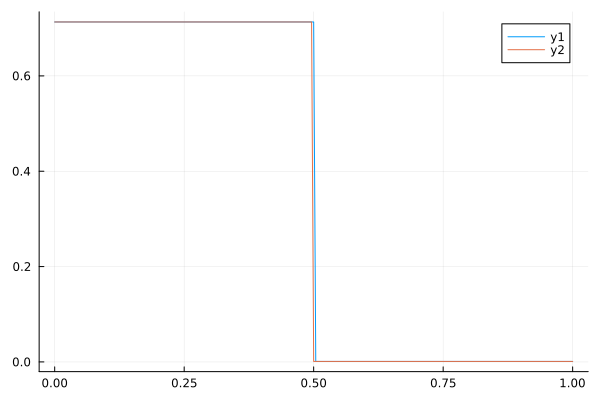

In [25]:
x_2 = LinRange(0,L,N-1)
plot(x_2,SSL)
plot!(x_2,SSR)

In [26]:
D_final = [U[i][1] for i in 1:N]

p_final = [pressure_nu(U[i])[1] for i in 1:N]

v_final = [pressure_nu(U[i])[2] for i in 1:N]

e_final = [pressure_nu(U[i])[3] for i in 1:N];



In [27]:
maximum(v_final)*(dt/dx)

1.25e-7

In [28]:
p_final;

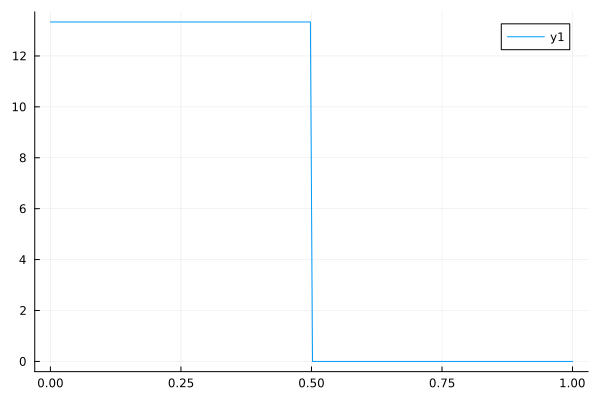

In [29]:
plot(x,p_final)

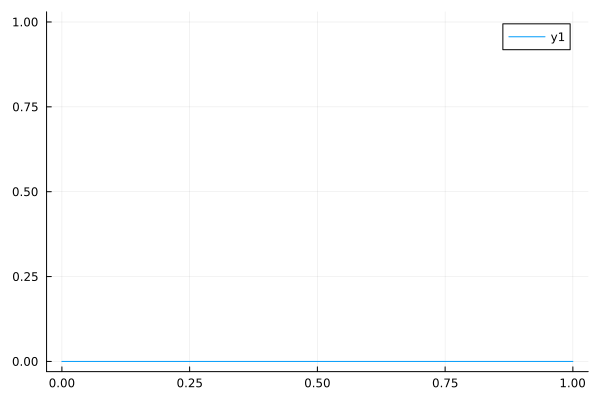

In [30]:
plot(x,v_final)

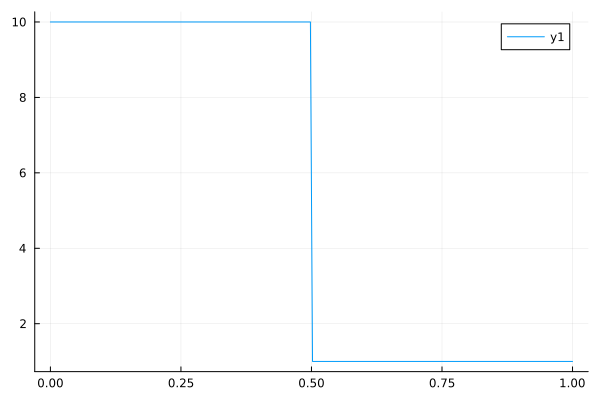

In [31]:
plot(x,D_final)

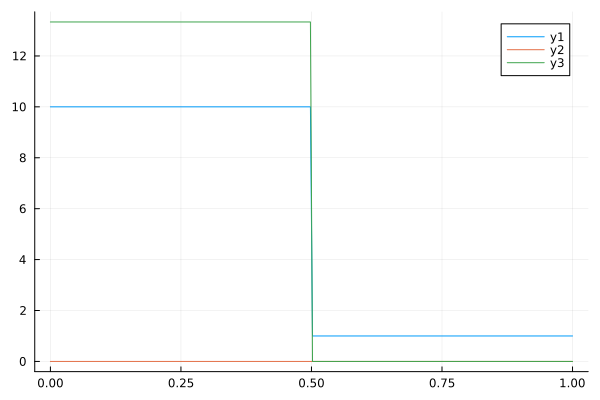

In [32]:
plot(x,D_final)
plot!(x,v_final)
plot!(x,p_final)

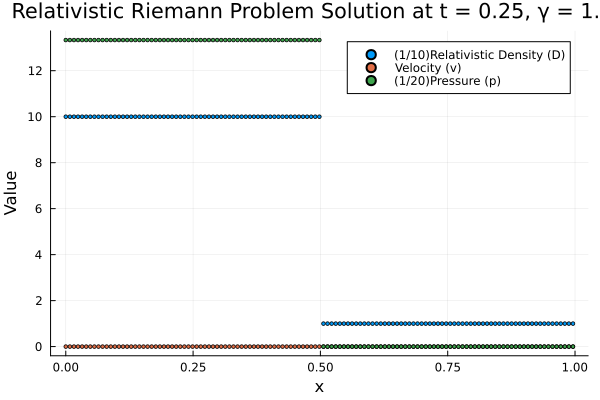

In [33]:
scatter(x[1:2:end], D_final[1:2:end], label="(1/10)Relativistic Density (D)", xlabel="x", ylabel="Value", title="Relativistic Riemann Problem Solution at t = $T, γ = $γ", markersize=2)
scatter!(x[1:2:end], v_final[1:2:end], label="Velocity (v)", markersize=2)
scatter!(x[1:2:end], p_final[1:2:end], label="(1/20)Pressure (p)", markersize=2)

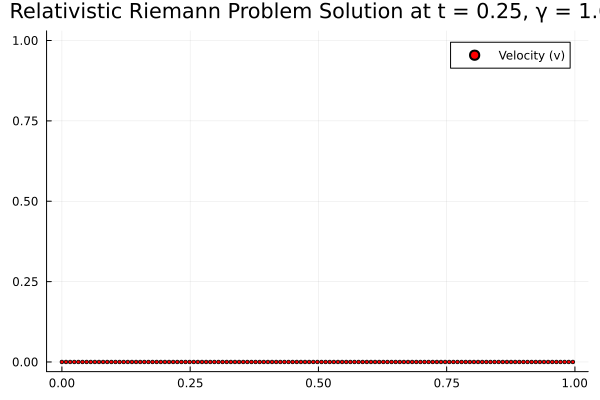

In [34]:
scatter(x[1:2:end], v_final[1:2:end], label="Velocity (v)", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:red)

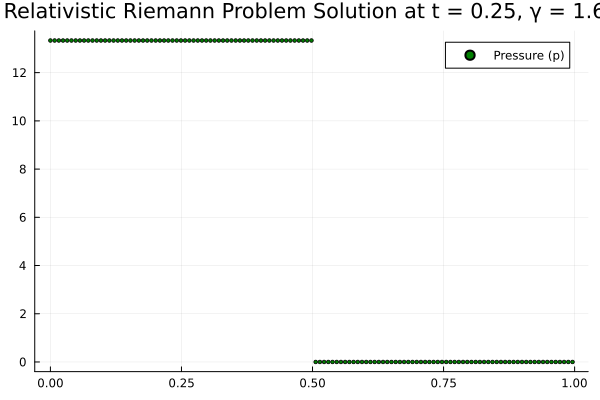

In [35]:
scatter(x[1:2:end], p_final[1:2:end], label="Pressure (p)", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:green)

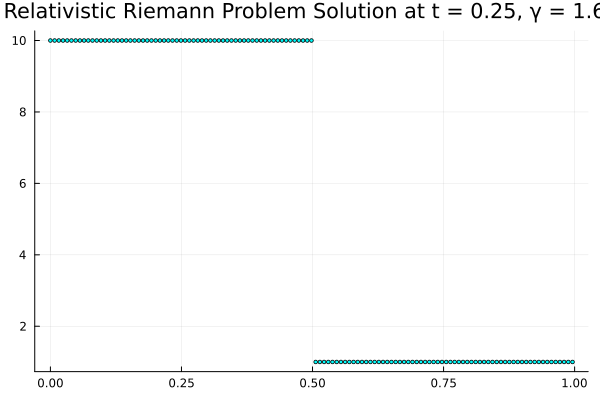

In [36]:
scatter(x[1:2:end], D_final[1:2:end], label="", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:cyan)

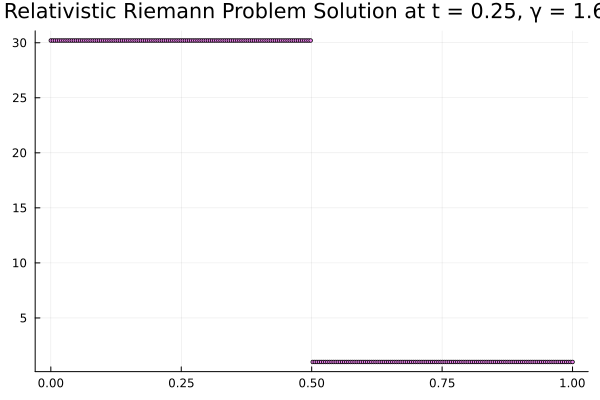

In [37]:
scatter(x[1:1:end], e_final[1:1:end], label="", markersize=2,title="Relativistic Riemann Problem Solution at t = $T, γ = $γ",color=:violet)

In [38]:
3/2

1.5

In [39]:
"""
using Plots
using Roots

# Parameters
γ = 1.4  # Adiabatic index for relativistic gas 5/3 , 4/3 , 1.999
c = 1.0  # Speed of light (set to 1 for simplicity)
N = 500  # Number of grid points
L = 1.0  # Domain length
dx = L / N  # Grid spacing
dt = 0.001  # Time step
T = 0.25  # Total simulation time
CFL = 0.9;  # CFL condition

# Initial condition for relativistic Riemann problem
function initial_condition(x)
    if x < 0.5
        ρ =  1.0  # Rest-mass density on the left  1.0, 10.0,2.0
        v =  0.0   # Velocity on the left
        p =  1.0  # Pressure on the left   1.0, 40.0/3 ,1990
    else
        ρ =  0.125  # Rest-mass density on the right 1.0,0.125,1.0
        v =  0.0    # Velocity on the right
        p =  0.1   # Pressure on the right 0.00001*(2/3) , 0.1 , 995
    end
    W = 1 / sqrt(1 - v^2)  # Lorentz factor
    h = 1 + (γ * p) / ((γ - 1) * ρ)  # Specific enthalpy
    D = ρ * W  # Relativistic mass density
    S = ρ * h * W^2 * v  # Momentum density
    E = ρ * h * W^2 - p   # Energy density
    return [D, S, E]
end

x1 = 0.8
print(initial_condition(x1))

function pressure_nu(U)
    D, S, E = U 
    function g(v)
        return ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2
    end
    # Debugging: Print the function values over the interval
    for v in LinRange(0, 1, 10)
        println("v = $v, g(v) = $(g(v))")
    end
    # Try finding the root with an initial guess
    vr = find_zero(g, 0.5)  # Initial guess of 0.5
    e = E - vr*S
    p = (γ - 1)*(E - vr*S)
    return [p, vr, e]
end

print(pressure_nu(initial_condition(x1)))
pressure_nu(initial_condition(x1))

function flux(U)
    D, S, E = U
    p = pressure_nu(U)[1]  # Pressure
    v = pressure_nu(U)[2]
    return [v * D, v * S + p, (p + E) * v]
end

flux(initial_condition(x1))

function relativistic_hlle_flux(U_L, U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    c_s_L = sqrt(γ * p_L / (U_L[1] + (γ/(γ-1))*p_L))
    c_s_R = sqrt(γ * p_R / (U_R[1] + (γ/(γ-1))*p_R))
    
    v_L = pressure_nu(U_L)[2]
    v_R = pressure_nu(U_R)[2]
    
    λ_L = min(0, (v_L - c_s_L) / (1 - v_L * c_s_L), (v_R - c_s_R) / (1 - v_R * c_s_R))
    λ_R = max(0, (v_L + c_s_L) / (1 + v_L * c_s_L), (v_R + c_s_R) / (1 + v_R * c_s_R))
    
    F_L = flux(U_L)
    F_R = flux(U_R)
    
    if λ_L >= 0
        return F_L
    elseif λ_R <= 0
        return F_R
    else
        return (λ_R * F_L - λ_L * F_R + λ_L * λ_R * (U_R - U_L)) / (λ_R - λ_L)
    end
end

x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_new = deepcopy(U)

relativistic_hlle_flux(U[250], U[251])
"""

LoadError: UndefVarError: `v` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [40]:
cc = 100/400
ct = (cc/3)
println(cc)
println(ct)
println(ct/cc)

0.25
0.08333333333333333
0.3333333333333333


In [41]:
sqrt(Complex(-9))

0.0 + 3.0im

In [42]:
5/3

1.6666666666666667

In [43]:
function MINMOD(a,b)
    sp = a
    sm = b
    print(sign(sp) + sign(sm))
  return 0.25 * (sign(sp) + sign(sm)) * min(abs(sp), abs(sm))
end

MINMOD (generic function with 1 method)

In [44]:
MIN(0,0)

LoadError: UndefVarError: `MIN` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Enter the value of γ : 
stdin> 1.4
0.5
125.0
[1.0, 0.0, 3.5]
[0.125, 0.0, 0.3750000000000001]
[0.9999999999998201, 5.0e-7, 3.4999999999995, 5.0e-7, 0.0, 4.8999999999999995, 0.9999999999999489]
[0.09999999999982383, 5.0e-7, 0.3749999999995001, 5.0e-7, 0.0, 0.5250000000000001, 0.12499999999994049]
Time step :0.0001 dt for next time step :0.0001
Time step :0.0002 dt for next time step :0.0001
Time step :0.00030000000000000003 dt for next time step :0.0001
Time step :0.0004 dt for next time step :0.0001
Time step :0.0005 dt for next time step :0.0001
Time step :0.0006000000000000001 dt for next time step :0.0001
Time step :0.0007000000000000001 dt for next time step :0.0001
Time step :0.0008000000000000001 dt for next time step :0.0001
Time step :0.0009000000000000002 dt for next time step :0.0001
Time step :0.0010000000000000002 dt for next time step :0.0001
Time step :0.0011000000000000003 dt for next time step :0.0001
Time step :0.0012000000000000003 dt for next time step :0.0001
Time s

Time step :0.013199999999999976 dt for next time step :0.0001
Time step :0.013299999999999975 dt for next time step :0.0001
Time step :0.013399999999999974 dt for next time step :0.0001
Time step :0.013499999999999974 dt for next time step :0.0001
Time step :0.013599999999999973 dt for next time step :0.0001
Time step :0.013699999999999973 dt for next time step :0.0001
Time step :0.013799999999999972 dt for next time step :0.0001
Time step :0.013899999999999971 dt for next time step :0.0001
Time step :0.01399999999999997 dt for next time step :0.0001
Time step :0.01409999999999997 dt for next time step :0.0001
Time step :0.01419999999999997 dt for next time step :0.0001
Time step :0.014299999999999969 dt for next time step :0.0001
Time step :0.014399999999999968 dt for next time step :0.0001
Time step :0.014499999999999968 dt for next time step :0.0001
Time step :0.014599999999999967 dt for next time step :0.0001
Time step :0.014699999999999967 dt for next time step :0.0001
Time step :

Time step :0.026699999999999894 dt for next time step :0.0001
Time step :0.026799999999999893 dt for next time step :0.0001
Time step :0.026899999999999893 dt for next time step :0.0001
Time step :0.026999999999999892 dt for next time step :0.0001
Time step :0.02709999999999989 dt for next time step :0.0001
Time step :0.02719999999999989 dt for next time step :0.0001
Time step :0.02729999999999989 dt for next time step :0.0001
Time step :0.02739999999999989 dt for next time step :0.0001
Time step :0.02749999999999989 dt for next time step :0.0001
Time step :0.02759999999999989 dt for next time step :0.0001
Time step :0.027699999999999888 dt for next time step :0.0001
Time step :0.027799999999999887 dt for next time step :0.0001
Time step :0.027899999999999887 dt for next time step :0.0001
Time step :0.027999999999999886 dt for next time step :0.0001
Time step :0.028099999999999885 dt for next time step :0.0001
Time step :0.028199999999999885 dt for next time step :0.0001
Time step :0.0

Time step :0.040200000000000125 dt for next time step :0.0001
Time step :0.04030000000000013 dt for next time step :0.0001
Time step :0.04040000000000013 dt for next time step :0.0001
Time step :0.04050000000000013 dt for next time step :0.0001
Time step :0.040600000000000136 dt for next time step :0.0001
Time step :0.04070000000000014 dt for next time step :0.0001
Time step :0.04080000000000014 dt for next time step :0.0001
Time step :0.040900000000000145 dt for next time step :0.0001
Time step :0.04100000000000015 dt for next time step :0.0001
Time step :0.04110000000000015 dt for next time step :0.0001
Time step :0.04120000000000015 dt for next time step :0.0001
Time step :0.041300000000000156 dt for next time step :0.0001
Time step :0.04140000000000016 dt for next time step :0.0001
Time step :0.04150000000000016 dt for next time step :0.0001
Time step :0.041600000000000165 dt for next time step :0.0001
Time step :0.04170000000000017 dt for next time step :0.0001
Time step :0.041800

Time step :0.05370000000000051 dt for next time step :0.0001
Time step :0.053800000000000514 dt for next time step :0.0001
Time step :0.05390000000000052 dt for next time step :0.0001
Time step :0.05400000000000052 dt for next time step :0.0001
Time step :0.05410000000000052 dt for next time step :0.0001
Time step :0.054200000000000526 dt for next time step :0.0001
Time step :0.05430000000000053 dt for next time step :0.0001
Time step :0.05440000000000053 dt for next time step :0.0001
Time step :0.054500000000000534 dt for next time step :0.0001
Time step :0.05460000000000054 dt for next time step :0.0001
Time step :0.05470000000000054 dt for next time step :0.0001
Time step :0.05480000000000054 dt for next time step :0.0001
Time step :0.054900000000000546 dt for next time step :0.0001
Time step :0.05500000000000055 dt for next time step :0.0001
Time step :0.05510000000000055 dt for next time step :0.0001
Time step :0.055200000000000554 dt for next time step :0.0001
Time step :0.055300

Time step :0.0673000000000009 dt for next time step :0.0001
Time step :0.0674000000000009 dt for next time step :0.0001
Time step :0.0675000000000009 dt for next time step :0.0001
Time step :0.06760000000000091 dt for next time step :0.0001
Time step :0.06770000000000091 dt for next time step :0.0001
Time step :0.06780000000000092 dt for next time step :0.0001
Time step :0.06790000000000092 dt for next time step :0.0001
Time step :0.06800000000000092 dt for next time step :0.0001
Time step :0.06810000000000092 dt for next time step :0.0001
Time step :0.06820000000000093 dt for next time step :0.0001
Time step :0.06830000000000093 dt for next time step :0.0001
Time step :0.06840000000000093 dt for next time step :0.0001
Time step :0.06850000000000094 dt for next time step :0.0001
Time step :0.06860000000000094 dt for next time step :0.0001
Time step :0.06870000000000094 dt for next time step :0.0001
Time step :0.06880000000000094 dt for next time step :0.0001
Time step :0.06890000000000

Time step :0.08080000000000129 dt for next time step :0.0001
Time step :0.08090000000000129 dt for next time step :0.0001
Time step :0.0810000000000013 dt for next time step :0.0001
Time step :0.0811000000000013 dt for next time step :0.0001
Time step :0.0812000000000013 dt for next time step :0.0001
Time step :0.0813000000000013 dt for next time step :0.0001
Time step :0.0814000000000013 dt for next time step :0.0001
Time step :0.08150000000000131 dt for next time step :0.0001
Time step :0.08160000000000131 dt for next time step :0.0001
Time step :0.08170000000000131 dt for next time step :0.0001
Time step :0.08180000000000132 dt for next time step :0.0001
Time step :0.08190000000000132 dt for next time step :0.0001
Time step :0.08200000000000132 dt for next time step :0.0001
Time step :0.08210000000000132 dt for next time step :0.0001
Time step :0.08220000000000133 dt for next time step :0.0001
Time step :0.08230000000000133 dt for next time step :0.0001
Time step :0.0824000000000013

Time step :0.09440000000000168 dt for next time step :0.0001
Time step :0.09450000000000168 dt for next time step :0.0001
Time step :0.09460000000000168 dt for next time step :0.0001
Time step :0.09470000000000169 dt for next time step :0.0001
Time step :0.09480000000000169 dt for next time step :0.0001
Time step :0.09490000000000169 dt for next time step :0.0001
Time step :0.0950000000000017 dt for next time step :0.0001
Time step :0.0951000000000017 dt for next time step :0.0001
Time step :0.0952000000000017 dt for next time step :0.0001
Time step :0.0953000000000017 dt for next time step :0.0001
Time step :0.0954000000000017 dt for next time step :0.0001
Time step :0.09550000000000171 dt for next time step :0.0001
Time step :0.09560000000000171 dt for next time step :0.0001
Time step :0.09570000000000171 dt for next time step :0.0001
Time step :0.09580000000000172 dt for next time step :0.0001
Time step :0.09590000000000172 dt for next time step :0.0001
Time step :0.0960000000000017

Time step :0.10790000000000206 dt for next time step :0.0001
Time step :0.10800000000000207 dt for next time step :0.0001
Time step :0.10810000000000207 dt for next time step :0.0001
Time step :0.10820000000000207 dt for next time step :0.0001
Time step :0.10830000000000208 dt for next time step :0.0001
Time step :0.10840000000000208 dt for next time step :0.0001
Time step :0.10850000000000208 dt for next time step :0.0001
Time step :0.10860000000000208 dt for next time step :0.0001
Time step :0.10870000000000209 dt for next time step :0.0001
Time step :0.10880000000000209 dt for next time step :0.0001
Time step :0.10890000000000209 dt for next time step :0.0001
Time step :0.1090000000000021 dt for next time step :0.0001
Time step :0.1091000000000021 dt for next time step :0.0001
Time step :0.1092000000000021 dt for next time step :0.0001
Time step :0.1093000000000021 dt for next time step :0.0001
Time step :0.1094000000000021 dt for next time step :0.0001
Time step :0.1095000000000021

Time step :0.12150000000000245 dt for next time step :0.0001
Time step :0.12160000000000246 dt for next time step :0.0001
Time step :0.12170000000000246 dt for next time step :0.0001
Time step :0.12180000000000246 dt for next time step :0.0001
Time step :0.12190000000000246 dt for next time step :0.0001
Time step :0.12200000000000247 dt for next time step :0.0001
Time step :0.12210000000000247 dt for next time step :0.0001
Time step :0.12220000000000247 dt for next time step :0.0001
Time step :0.12230000000000248 dt for next time step :0.0001
Time step :0.12240000000000248 dt for next time step :0.0001
Time step :0.12250000000000248 dt for next time step :0.0001
Time step :0.12260000000000248 dt for next time step :0.0001
Time step :0.12270000000000249 dt for next time step :0.0001
Time step :0.12280000000000249 dt for next time step :0.0001
Time step :0.1229000000000025 dt for next time step :0.0001
Time step :0.1230000000000025 dt for next time step :0.0001
Time step :0.1231000000000

Time step :0.13510000000000144 dt for next time step :0.0001
Time step :0.13520000000000143 dt for next time step :0.0001
Time step :0.13530000000000142 dt for next time step :0.0001
Time step :0.1354000000000014 dt for next time step :0.0001
Time step :0.1355000000000014 dt for next time step :0.0001
Time step :0.13560000000000139 dt for next time step :0.0001
Time step :0.13570000000000138 dt for next time step :0.0001
Time step :0.13580000000000136 dt for next time step :0.0001
Time step :0.13590000000000135 dt for next time step :0.0001
Time step :0.13600000000000134 dt for next time step :0.0001
Time step :0.13610000000000133 dt for next time step :0.0001
Time step :0.13620000000000132 dt for next time step :0.0001
Time step :0.1363000000000013 dt for next time step :0.0001
Time step :0.1364000000000013 dt for next time step :0.0001
Time step :0.1365000000000013 dt for next time step :0.0001
Time step :0.13660000000000128 dt for next time step :0.0001
Time step :0.1367000000000012

Time step :0.14869999999999994 dt for next time step :0.0001
Time step :0.14879999999999993 dt for next time step :0.0001
Time step :0.14889999999999992 dt for next time step :0.0001
Time step :0.1489999999999999 dt for next time step :0.0001
Time step :0.1490999999999999 dt for next time step :0.0001
Time step :0.1491999999999999 dt for next time step :0.0001
Time step :0.14929999999999988 dt for next time step :0.0001
Time step :0.14939999999999987 dt for next time step :0.0001
Time step :0.14949999999999986 dt for next time step :0.0001
Time step :0.14959999999999984 dt for next time step :0.0001
Time step :0.14969999999999983 dt for next time step :0.0001
Time step :0.14979999999999982 dt for next time step :0.0001
Time step :0.1498999999999998 dt for next time step :0.0001
Time step :0.1499999999999998 dt for next time step :0.0001
Time step :0.1500999999999998 dt for next time step :0.0001
Time step :0.15019999999999978 dt for next time step :0.0001
Time step :0.15029999999999977

Time step :0.16229999999999845 dt for next time step :0.0001
Time step :0.16239999999999843 dt for next time step :0.0001
Time step :0.16249999999999842 dt for next time step :0.0001
Time step :0.1625999999999984 dt for next time step :0.0001
Time step :0.1626999999999984 dt for next time step :0.0001
Time step :0.1627999999999984 dt for next time step :0.0001
Time step :0.16289999999999838 dt for next time step :0.0001
Time step :0.16299999999999837 dt for next time step :0.0001
Time step :0.16309999999999836 dt for next time step :0.0001
Time step :0.16319999999999835 dt for next time step :0.0001
Time step :0.16329999999999834 dt for next time step :0.0001
Time step :0.16339999999999832 dt for next time step :0.0001
Time step :0.1634999999999983 dt for next time step :0.0001
Time step :0.1635999999999983 dt for next time step :0.0001
Time step :0.1636999999999983 dt for next time step :0.0001
Time step :0.16379999999999828 dt for next time step :0.0001
Time step :0.16389999999999827

Time step :0.17589999999999695 dt for next time step :0.0001
Time step :0.17599999999999694 dt for next time step :0.0001
Time step :0.17609999999999693 dt for next time step :0.0001
Time step :0.17619999999999691 dt for next time step :0.0001
Time step :0.1762999999999969 dt for next time step :0.0001
Time step :0.1763999999999969 dt for next time step :0.0001
Time step :0.17649999999999688 dt for next time step :0.0001
Time step :0.17659999999999687 dt for next time step :0.0001
Time step :0.17669999999999686 dt for next time step :0.0001
Time step :0.17679999999999685 dt for next time step :0.0001
Time step :0.17689999999999684 dt for next time step :0.0001
Time step :0.17699999999999683 dt for next time step :0.0001
Time step :0.17709999999999682 dt for next time step :0.0001
Time step :0.1771999999999968 dt for next time step :0.0001
Time step :0.1772999999999968 dt for next time step :0.0001
Time step :0.17739999999999678 dt for next time step :0.0001
Time step :0.177499999999996

Time step :0.18949999999999545 dt for next time step :0.0001
Time step :0.18959999999999544 dt for next time step :0.0001
Time step :0.18969999999999543 dt for next time step :0.0001
Time step :0.18979999999999542 dt for next time step :0.0001
Time step :0.1898999999999954 dt for next time step :0.0001
Time step :0.1899999999999954 dt for next time step :0.0001
Time step :0.19009999999999538 dt for next time step :0.0001
Time step :0.19019999999999537 dt for next time step :0.0001
Time step :0.19029999999999536 dt for next time step :0.0001
Time step :0.19039999999999535 dt for next time step :0.0001
Time step :0.19049999999999534 dt for next time step :0.0001
Time step :0.19059999999999533 dt for next time step :0.0001
Time step :0.19069999999999532 dt for next time step :0.0001
Time step :0.1907999999999953 dt for next time step :0.0001
Time step :0.1908999999999953 dt for next time step :0.0001
Time step :0.19099999999999528 dt for next time step :0.0001
Time step :0.191099999999995

Time step :0.20309999999999395 dt for next time step :0.0001
Time step :0.20319999999999394 dt for next time step :0.0001
Time step :0.20329999999999393 dt for next time step :0.0001
Time step :0.20339999999999392 dt for next time step :0.0001
Time step :0.2034999999999939 dt for next time step :0.0001
Time step :0.2035999999999939 dt for next time step :0.0001
Time step :0.20369999999999389 dt for next time step :0.0001
Time step :0.20379999999999387 dt for next time step :0.0001
Time step :0.20389999999999386 dt for next time step :0.0001
Time step :0.20399999999999385 dt for next time step :0.0001
Time step :0.20409999999999384 dt for next time step :0.0001
Time step :0.20419999999999383 dt for next time step :0.0001
Time step :0.20429999999999382 dt for next time step :0.0001
Time step :0.2043999999999938 dt for next time step :0.0001
Time step :0.2044999999999938 dt for next time step :0.0001
Time step :0.2045999999999938 dt for next time step :0.0001
Time step :0.2046999999999937

Time step :0.21669999999999245 dt for next time step :0.0001
Time step :0.21679999999999244 dt for next time step :0.0001
Time step :0.21689999999999243 dt for next time step :0.0001
Time step :0.21699999999999242 dt for next time step :0.0001
Time step :0.2170999999999924 dt for next time step :0.0001
Time step :0.2171999999999924 dt for next time step :0.0001
Time step :0.2172999999999924 dt for next time step :0.0001
Time step :0.21739999999999238 dt for next time step :0.0001
Time step :0.21749999999999237 dt for next time step :0.0001
Time step :0.21759999999999236 dt for next time step :0.0001
Time step :0.21769999999999234 dt for next time step :0.0001
Time step :0.21779999999999233 dt for next time step :0.0001
Time step :0.21789999999999232 dt for next time step :0.0001
Time step :0.2179999999999923 dt for next time step :0.0001
Time step :0.2180999999999923 dt for next time step :0.0001
Time step :0.2181999999999923 dt for next time step :0.0001
Time step :0.21829999999999228

Time step :0.23029999999999096 dt for next time step :0.0001
Time step :0.23039999999999095 dt for next time step :0.0001
Time step :0.23049999999999093 dt for next time step :0.0001
Time step :0.23059999999999092 dt for next time step :0.0001
Time step :0.2306999999999909 dt for next time step :0.0001
Time step :0.2307999999999909 dt for next time step :0.0001
Time step :0.2308999999999909 dt for next time step :0.0001
Time step :0.23099999999999088 dt for next time step :0.0001
Time step :0.23109999999999087 dt for next time step :0.0001
Time step :0.23119999999999086 dt for next time step :0.0001
Time step :0.23129999999999085 dt for next time step :0.0001
Time step :0.23139999999999084 dt for next time step :0.0001
Time step :0.23149999999999082 dt for next time step :0.0001
Time step :0.2315999999999908 dt for next time step :0.0001
Time step :0.2316999999999908 dt for next time step :0.0001
Time step :0.2317999999999908 dt for next time step :0.0001
Time step :0.23189999999999078

Time step :0.24399999999998945 dt for next time step :0.0001
Time step :0.24409999999998944 dt for next time step :0.0001
Time step :0.24419999999998943 dt for next time step :0.0001
Time step :0.24429999999998941 dt for next time step :0.0001
Time step :0.2443999999999894 dt for next time step :0.0001
Time step :0.2444999999999894 dt for next time step :0.0001
Time step :0.24459999999998938 dt for next time step :0.0001
Time step :0.24469999999998937 dt for next time step :0.0001
Time step :0.24479999999998936 dt for next time step :0.0001
Time step :0.24489999999998935 dt for next time step :0.0001
Time step :0.24499999999998934 dt for next time step :0.0001
Time step :0.24509999999998933 dt for next time step :0.0001
Time step :0.24519999999998932 dt for next time step :0.0001
Time step :0.2452999999999893 dt for next time step :0.0001
Time step :0.2453999999999893 dt for next time step :0.0001
Time step :0.24549999999998928 dt for next time step :0.0001
Time step :0.245599999999989

Time step :0.25759999999998795 dt for next time step :0.0001
Time step :0.25769999999998794 dt for next time step :0.0001
Time step :0.2577999999999879 dt for next time step :0.0001
Time step :0.2578999999999879 dt for next time step :0.0001
Time step :0.2579999999999879 dt for next time step :0.0001
Time step :0.2580999999999879 dt for next time step :0.0001
Time step :0.2581999999999879 dt for next time step :0.0001
Time step :0.2582999999999879 dt for next time step :0.0001
Time step :0.25839999999998786 dt for next time step :0.0001
Time step :0.25849999999998785 dt for next time step :0.0001
Time step :0.25859999999998784 dt for next time step :0.0001
Time step :0.25869999999998783 dt for next time step :0.0001
Time step :0.2587999999999878 dt for next time step :0.0001
Time step :0.2588999999999878 dt for next time step :0.0001
Time step :0.2589999999999878 dt for next time step :0.0001
Time step :0.2590999999999878 dt for next time step :0.0001
Time step :0.2591999999999878 dt f

Time step :0.27119999999998645 dt for next time step :0.0001
Time step :0.27129999999998644 dt for next time step :0.0001
Time step :0.27139999999998643 dt for next time step :0.0001
Time step :0.2714999999999864 dt for next time step :0.0001
Time step :0.2715999999999864 dt for next time step :0.0001
Time step :0.2716999999999864 dt for next time step :0.0001
Time step :0.2717999999999864 dt for next time step :0.0001
Time step :0.2718999999999864 dt for next time step :0.0001
Time step :0.27199999999998636 dt for next time step :0.0001
Time step :0.27209999999998635 dt for next time step :0.0001
Time step :0.27219999999998634 dt for next time step :0.0001
Time step :0.27229999999998633 dt for next time step :0.0001
Time step :0.2723999999999863 dt for next time step :0.0001
Time step :0.2724999999999863 dt for next time step :0.0001
Time step :0.2725999999999863 dt for next time step :0.0001
Time step :0.2726999999999863 dt for next time step :0.0001
Time step :0.2727999999999863 dt 

Time step :0.28479999999998495 dt for next time step :0.0001
Time step :0.28489999999998494 dt for next time step :0.0001
Time step :0.28499999999998493 dt for next time step :0.0001
Time step :0.2850999999999849 dt for next time step :0.0001
Time step :0.2851999999999849 dt for next time step :0.0001
Time step :0.2852999999999849 dt for next time step :0.0001
Time step :0.2853999999999849 dt for next time step :0.0001
Time step :0.2854999999999849 dt for next time step :0.0001
Time step :0.28559999999998487 dt for next time step :0.0001
Time step :0.28569999999998485 dt for next time step :0.0001
Time step :0.28579999999998484 dt for next time step :0.0001
Time step :0.28589999999998483 dt for next time step :0.0001
Time step :0.2859999999999848 dt for next time step :0.0001
Time step :0.2860999999999848 dt for next time step :0.0001
Time step :0.2861999999999848 dt for next time step :0.0001
Time step :0.2862999999999848 dt for next time step :0.0001
Time step :0.2863999999999848 dt 

Time step :0.29839999999998346 dt for next time step :0.0001
Time step :0.29849999999998345 dt for next time step :0.0001
Time step :0.29859999999998343 dt for next time step :0.0001
Time step :0.2986999999999834 dt for next time step :0.0001
Time step :0.2987999999999834 dt for next time step :0.0001
Time step :0.2988999999999834 dt for next time step :0.0001
Time step :0.2989999999999834 dt for next time step :0.0001
Time step :0.2990999999999834 dt for next time step :0.0001
Time step :0.29919999999998337 dt for next time step :0.0001
Time step :0.29929999999998336 dt for next time step :0.0001
Time step :0.29939999999998335 dt for next time step :0.0001
Time step :0.29949999999998334 dt for next time step :0.0001
Time step :0.2995999999999833 dt for next time step :0.0001
Time step :0.2996999999999833 dt for next time step :0.0001
Time step :0.2997999999999833 dt for next time step :0.0001
Time step :0.2998999999999833 dt for next time step :0.0001
Time step :0.2999999999999833 dt 

Time step :0.31209999999998195 dt for next time step :0.0001
Time step :0.31219999999998194 dt for next time step :0.0001
Time step :0.3122999999999819 dt for next time step :0.0001
Time step :0.3123999999999819 dt for next time step :0.0001
Time step :0.3124999999999819 dt for next time step :0.0001
Time step :0.3125999999999819 dt for next time step :0.0001
Time step :0.3126999999999819 dt for next time step :0.0001
Time step :0.31279999999998187 dt for next time step :0.0001
Time step :0.31289999999998186 dt for next time step :0.0001
Time step :0.31299999999998185 dt for next time step :0.0001
Time step :0.31309999999998184 dt for next time step :0.0001
Time step :0.3131999999999818 dt for next time step :0.0001
Time step :0.3132999999999818 dt for next time step :0.0001
Time step :0.3133999999999818 dt for next time step :0.0001
Time step :0.3134999999999818 dt for next time step :0.0001
Time step :0.3135999999999818 dt for next time step :0.0001
Time step :0.31369999999998177 dt 

Time step :0.32579999999998044 dt for next time step :0.0001
Time step :0.3258999999999804 dt for next time step :0.0001
Time step :0.3259999999999804 dt for next time step :0.0001
Time step :0.3260999999999804 dt for next time step :0.0001
Time step :0.3261999999999804 dt for next time step :0.0001
Time step :0.3262999999999804 dt for next time step :0.0001
Time step :0.3263999999999804 dt for next time step :0.0001
Time step :0.32649999999998036 dt for next time step :0.0001
Time step :0.32659999999998035 dt for next time step :0.0001
Time step :0.32669999999998034 dt for next time step :0.0001
Time step :0.32679999999998033 dt for next time step :0.0001
Time step :0.3268999999999803 dt for next time step :0.0001
Time step :0.3269999999999803 dt for next time step :0.0001
Time step :0.3270999999999803 dt for next time step :0.0001
Time step :0.3271999999999803 dt for next time step :0.0001
Time step :0.3272999999999803 dt for next time step :0.0001
Time step :0.32739999999998026 dt f

Time step :0.33939999999997894 dt for next time step :0.0001
Time step :0.33949999999997893 dt for next time step :0.0001
Time step :0.3395999999999789 dt for next time step :0.0001
Time step :0.3396999999999789 dt for next time step :0.0001
Time step :0.3397999999999789 dt for next time step :0.0001
Time step :0.3398999999999789 dt for next time step :0.0001
Time step :0.3399999999999789 dt for next time step :0.0001
Time step :0.34009999999997886 dt for next time step :0.0001
Time step :0.34019999999997885 dt for next time step :0.0001
Time step :0.34029999999997884 dt for next time step :0.0001
Time step :0.34039999999997883 dt for next time step :0.0001
Time step :0.3404999999999788 dt for next time step :0.0001
Time step :0.3405999999999788 dt for next time step :0.0001
Time step :0.3406999999999788 dt for next time step :0.0001
Time step :0.3407999999999788 dt for next time step :0.0001
Time step :0.3408999999999788 dt for next time step :0.0001
Time step :0.34099999999997876 dt 

Time step :0.35299999999997744 dt for next time step :0.0001
Time step :0.35309999999997743 dt for next time step :0.0001
Time step :0.3531999999999774 dt for next time step :0.0001
Time step :0.3532999999999774 dt for next time step :0.0001
Time step :0.3533999999999774 dt for next time step :0.0001
Time step :0.3534999999999774 dt for next time step :0.0001
Time step :0.3535999999999774 dt for next time step :0.0001
Time step :0.35369999999997737 dt for next time step :0.0001
Time step :0.35379999999997735 dt for next time step :0.0001
Time step :0.35389999999997734 dt for next time step :0.0001
Time step :0.35399999999997733 dt for next time step :0.0001
Time step :0.3540999999999773 dt for next time step :0.0001
Time step :0.3541999999999773 dt for next time step :0.0001
Time step :0.3542999999999773 dt for next time step :0.0001
Time step :0.3543999999999773 dt for next time step :0.0001
Time step :0.3544999999999773 dt for next time step :0.0001
Time step :0.35459999999997727 dt 

Time step :0.36669999999997593 dt for next time step :0.0001
Time step :0.3667999999999759 dt for next time step :0.0001
Time step :0.3668999999999759 dt for next time step :0.0001
Time step :0.3669999999999759 dt for next time step :0.0001
Time step :0.3670999999999759 dt for next time step :0.0001
Time step :0.3671999999999759 dt for next time step :0.0001
Time step :0.36729999999997587 dt for next time step :0.0001
Time step :0.36739999999997586 dt for next time step :0.0001
Time step :0.36749999999997585 dt for next time step :0.0001
Time step :0.36759999999997583 dt for next time step :0.0001
Time step :0.3676999999999758 dt for next time step :0.0001
Time step :0.3677999999999758 dt for next time step :0.0001
Time step :0.3678999999999758 dt for next time step :0.0001
Time step :0.3679999999999758 dt for next time step :0.0001
Time step :0.3680999999999758 dt for next time step :0.0001
Time step :0.36819999999997577 dt for next time step :0.0001
Time step :0.36829999999997576 dt 

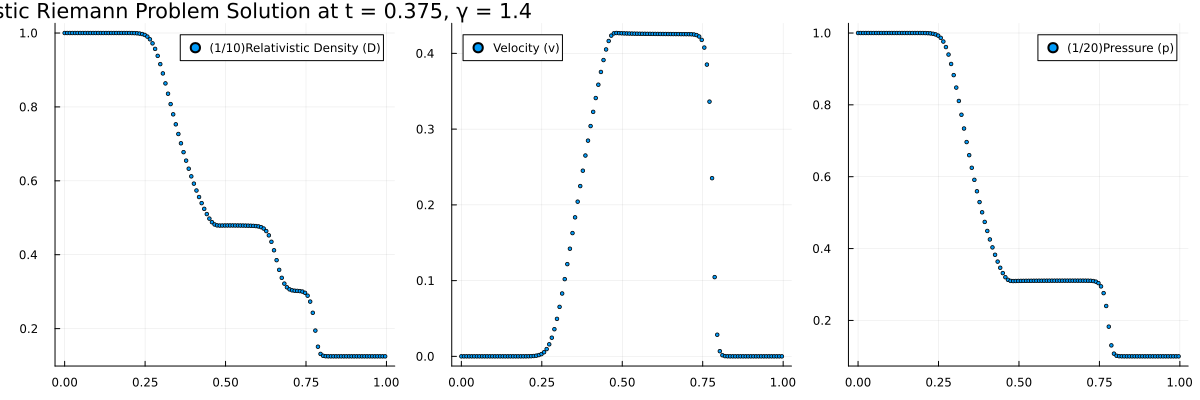

In [54]:
using Plots

# Parameters

#γ = 4/3  # Adiabatic index for relativistic gas 5/3 , 4/3 , 1.999


println("Enter the value of γ : ")
γ = parse(Float64, readline())

if γ > 2 || γ <= 1
    println("Unphysical Adiabatic Constant")
    exit()  
end


c = 1.0  # Speed of light 
N = 250  # Number of grid points
L = 1.0  # Domain length
L_mid = L / 2

N_mid = N / 2
dx = L / N  # Grid spacing
dt = 0.0001  # Time step
T = 0.375  # Total simulation time
CFL = 0.001;  # CFL condition
println(L_mid)
println(N_mid)



# Initial condition 
function initial_condition(x)
    if x < L_mid
        ρ =  1.0  # Rest-mass density on the left  1.0, 10.0,2.0
        v =  0.0  # Velocity on the left
        p =  1.0   #(1/3)*13  # Pressure on the left   1.0, 40.0/3 ,1990
    else
        ρ =  0.125  # Rest-mass density on the right 1.0,0.125,1.0
        v =  0.0    # Velocity on the right
        p =  0.1    #(2/3)*(10^-6)   # Pressure on the right (1e-6)*(2/3) , 0.1 , 995
    end
    W = 1 / sqrt(1 - v^2)  # Lorentz factor
    #h = 1 + (γ * p) / ((γ - 1) * ρ)  # Specific enthalpy with equation of state  p = (γ - 1)(e - ρ)
    #h = (γ * p) / ((γ - 1) * ρ)  # Specific Enthalpy with equation of state p = (γ - 1)*p 
    
    
    e = (p / (γ - 1) ) + ρ
    
    D = ρ * W  # Relativistic mass density
    S = (e + p) * W^2 * v  # Momentum density
    E = (e + p) * W^2 - p   # Energy density
    
    if W > 1e8
        print("Warning the speed is very close to speed of light")
    end
    
    if E < D && E < S
        return println("Warning: Physical constraints violated in initial_condition at  x = $x")
    else
        return [D, S, E]
    end
end
x1 = 0.2
x2 = 0.8
println(initial_condition(x1))
println(initial_condition(x2))




#ROOT FINDING

using Roots

δ = 1e-6

function pressure_nu(U)
    D,S,E = U 
    function g(v)
        return ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2 - v^2 * (1 - v^2) * ((γ - 1)*D - (1/γ)*D*(γ - 1)^2)^2
        #return  ((v * E - S) + (γ - 1) * S * (1 - v^2)*(1 / γ))^2
    end
    
    vu = min(1,S/E + δ)
    
#    vl = 0.0
    
    dsq = (γ*E)^2 - 4*(γ - 1)*S^2
    
    if dsq < 0
        print("discreminant is negative unphysical solution")
    end
    d = sqrt(dsq)
    
    ϵ = 1e-6
    
    if S == 0.0
        S = (S + ϵ)
    else
        S = S
    end
    
    vl = (1/(2*S*(γ - 1))) * (γ*E - d)

    
    #v0 = 0.5*(1 - D/E)*(vl - vu) + 0.5*(vl + vu) 
    
    v0 =  0.5*(vl + vu) 
    
    
    
#    vroot = find_zero(g, v0, maxiters = 20)

    vroot = find_zero(g, v0, atol = 1e-6)
    e = E - vroot*S
    #p = (γ - 1)*(E - vroot*S) 
    Wsq = (E + (γ - 1) * e) / (γ * e)
        if Wsq < 0
            error("W^2 (Lorentz factor squared) is negative")
        end
    
    W1 = sqrt(Wsq)
    n = D / W1
   #p = (γ - 1)*e 
    p = (γ - 1) * (e - n)
    
    return [p, vroot, e, v0, vl, d , n]
end

println(pressure_nu(initial_condition(x1)))

println(pressure_nu(initial_condition(x2)))




# FLUX 
function flux(U)
    D, S, E = U
    p = pressure_nu(U)[1]  # Pressure
    v = pressure_nu(U)[2]  # speed
    return [v * D, v * S + p, (p + E) * v]
end

flux(initial_condition(x1))


# RHLLE FLUX

function relativistic_hlle_flux(U_L,U_R)
    p_L = pressure_nu(U_L)[1]
    p_R = pressure_nu(U_R)[1]
    
    e_L = pressure_nu(U_L)[2]
    e_R = pressure_nu(U_R)[2]
    
    n_L = pressure_nu(U_L)[7]
    n_R = pressure_nu(U_R)[7]
    
   if  γ < 1.5
       c_s_L_2 = γ * p_L / (n_L + (γ/(γ-1))*p_L) 
       c_s_R_2 = γ * p_R / (n_R + (γ/(γ-1))*p_R)
   else 
        c_s_L_2 = (γ*(γ - 1)*(e_L - n_L))/(n_L + γ*(e_L - n_L))  # Given in paper (also derived)
        c_s_R_2 = (γ*(γ - 1)*(e_R - n_R))/(n_R + γ*(e_R - n_R))  # Given in paper (also derived)
    end 
    
   #c_s_L_2 = (γ - 1)
   #c_s_R_2 = (γ - 1)
   
   #c_s_L_2 = (γ - 1)*(1 - (n_L/(e_L + p_L)))
   #c_s_R_2 = (γ - 1)*(1 - (n_R/(e_R + p_R)))
    
   
    
    
    if c_s_L_2 < 0  ||  c_s_R_2 < 0
    	error("Unphysical Sound speeds detected")
    end
    
    c_s_L = sqrt(c_s_L_2)
    c_s_R = sqrt(c_s_R_2)
    
    c_s_M = 0.5*(c_s_L + c_s_R)
    
    v_L = pressure_nu(U_L)[2]
    v_R = pressure_nu(U_R)[2]
    
    v_M = 0.5*(v_L + v_R)
    
    λ_L = min(0, (v_M - c_s_M) / (1 - v_M * c_s_M), (v_L - c_s_L) / (1 - v_L * c_s_L))
    
    λ_R = max(0, (v_M + c_s_M) / (1 + v_M * c_s_M), (v_R + c_s_R) / (1 + v_R * c_s_R))
    
    F_L = flux(U_L)
    F_R = flux(U_R)
    
    if λ_L >= 0
        return F_L
    elseif λ_R <= 0
        return F_R
    else
        return (λ_R * F_L - λ_L * F_R + λ_L * λ_R * (U_R - U_L)) / (λ_R - λ_L)
    end
end



#MINMOD SLOPE LIMITER SCHEME

function minmod_slope_limiter(U)
    NC = length(U) - 2  # Number of cells (excluding ghost cells)
    UL = deepcopy(U)    # Initialize UL with the same structure as U
    UR = deepcopy(U)    # Initialize UR with the same structure as U

    for j in 2:NC+1  # Loop over interior cells (adjusting for 1-based indexing)
        Ujm1 = U[j-1]
        Uj   = U[j]
        Ujp1 = U[j+1]

        # Compute differences for each component (D, S, E)
        sp = Ujp1 .- Uj  # Element-wise difference
        sm = Uj .- Ujm1  # Element-wise difference

        # Apply minmod to each component
        dU = 0.25 .* (sign.(sp) .+ sign.(sm)) .* min.(abs.(sp), abs.(sm))

        # Compute limited states
        Ujp = Uj .+ dU
        Ujm = Uj .- dU

        UL[j] = Ujp
        UR[j-1] = Ujm
    end

    return UL, UR
end



"""
function minmod_central_limiter(U) #::Vector{Vector{T}}) where T
    NC = length(U) - 2  # Number of cells (excluding ghost cells)
    UL = deepcopy(U)    # Initialize UL with the same structure as U
    UR = deepcopy(U)    # Initialize UR with the same structure as U

    for j in 2:NC+1  # Loop over interior cells (adjusting for 1-based indexing)
        Ujm1 = U[j-1]
        Uj   = U[j]
        Ujp1 = U[j+1]

        # Compute differences for each component
        sp = Ujp1 .- Uj  # Element-wise difference
        sm = Uj .- Ujm1  # Element-wise difference

        # Apply minmod limiter component-wise
        dU = 0.25 .* (sign.(sp) .+ sign.(sm)) .* min.(2 .* abs.(sp), 2 .* abs.(sm), 0.5 .* abs.(sp .+ sm))

        # Compute limited states
        UL[j] = Uj .+ dU
        UR[j-1] = Uj .- dU
    end

    return UL, UR
end
"""

"""
function minmod_superbee_limiter(U) #::Vector{Vector{T}}) where T
    NC = length(U) - 2  # Number of cells (excluding ghost cells)
    UL = deepcopy(U)    # Initialize UL with the same structure as U
    UR = deepcopy(U)    # Initialize UR with the same structure as U

    for j in 2:NC+1  # Loop over interior cells (adjusting for 1-based indexing)
        Ujm1 = U[j-1]
        Uj   = U[j]
        Ujp1 = U[j+1]

        # Compute differences for each component
        sp = Ujp1 .- Uj  # Element-wise difference
        sm = Uj .- Ujm1  # Element-wise difference

        # Compute signs
        ssp = sign.(sp)
        ssm = sign.(sm)

        # Compute absolute differences
        asp = abs.(sp)
        asm = abs.(sm)

        # Apply modified minmod limiter component-wise
        dU = 0.25 .* (ssp .+ ssm) .* min.(2 .* asp, 2 .* asm, max.(asp, asm))

        # Compute limited states
        UL[j] = Uj .+ dU
        UR[j-1] = Uj .- dU
    end

    return UL, UR
end
"""



# TIME EVOLUTION

using Base.Threads

# Create grid
x = LinRange(0, L, N)
U = [initial_condition(xi) for xi in x]
U_half_L = deepcopy(U)  # Left states at half time step
U_half_R = deepcopy(U)  # Right states at half time step
U_new = deepcopy(U)     # Final updated states

t = 0.0

while t <= T
    
    global t
    # Step 1: Apply minmod slope limiter
    
    UL, UR = minmod_slope_limiter(U)

    constraint_violated = false  # Flag for constraint violation

    # Step 2: Update primitive variables at half time step
    @threads for i in 2:N-1
        U_L = UL[i]
        U_R = UR[i]
        
        FL = flux(U_L)
        FR = flux(U_R)
        
        # Update half-step states
        U_half_L[i] = U_L - 0.5 * (dt / dx) * (FR - FL)
        U_half_R[i] = U_R - 0.5 * (dt / dx) * (FR - FL)
        
  

        # Ensure physical validity
        if U_half_L[i][3] < U_half_L[i][1] || U_half_L[i][3] < U_half_L[i][2] ||
           U_half_R[i][3] < U_half_R[i][1] || U_half_R[i][3] < U_half_R[i][2]
            println("Physical constraint violated at half time step of $t and index $i")
            constraint_violated = true
        end
    end

    if constraint_violated
        break
    end

    # Step 3: Apply RHLLE flux for final update
    constraint_violated = false
    @threads for j in 2:N-1
        U_L = U_half_L[j]
        U_R = U_half_R[j]
        
        F_L = relativistic_hlle_flux(U_half_L[j-1], U_half_R[j-1])
        F_R = relativistic_hlle_flux(U_L, U_R)
        
        U_new[j] = U[j] - (dt / dx) * (F_R - F_L)

        # Ensure physical validity
        if U_new[j][3] < U_new[j][1] || U_new[j][3] < U_new[j][2]
            println("Physical constraint violated at time $t and index $j")
            constraint_violated = true
        end
    end

    if constraint_violated
        break
    end

    # Apply transmissive boundary conditions
    U_new[1] = U_new[2]
    U_new[end] = U_new[end-1]

    # Update solution for next time step
    U .= U_new
    
    v_final = [pressure_nu(U[i])[2] for i in 1:N]
    
    #global dt = CFL * dx / maximum(v_final)

    global t = t + dt 
    println("Time step :", t , " dt for next time step :", dt)
end


D_final = [U[i][1] for i in 1:N]

p_final = [pressure_nu(U[i])[1] for i in 1:N]

v_final = [pressure_nu(U[i])[2] for i in 1:N]

e_final = [pressure_nu(U[i])[3] for i in 1:N];




println("THE CFL LIMIT: ", maximum(v_final) * (dt / dx))


plot1 = scatter(x[1:2:end], D_final[1:2:end], label="(1/10)Relativistic Density (D)", xlabel="x", ylabel="Value", title="Relativistic Riemann Problem Solution at t = $T, γ = $γ", markersize=2)

plot2 = scatter(x[1:2:end], v_final[1:2:end], label="Velocity (v)", markersize=2)

plot3 = scatter(x[1:2:end], p_final[1:2:end], label="(1/20)Pressure (p)", markersize=2)

plot(plot1, plot2, plot3, layout=(1,3), size=(1200,400))

#savefig("RHLLE_1D_SCHEME.svg") 





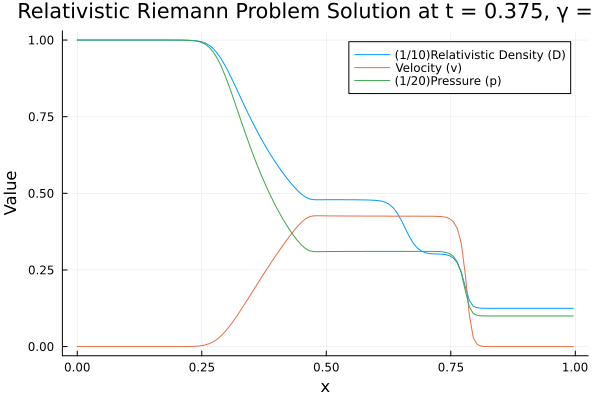

In [57]:
plot(x[1:2:end], D_final[1:2:end], label="(1/10)Relativistic Density (D)", xlabel="x", ylabel="Value", title="Relativistic Riemann Problem Solution at t = $T, γ = $γ", markersize=2)

plot!(x[1:2:end], v_final[1:2:end], label="Velocity (v)", markersize=2)

plot!(x[1:2:end], p_final[1:2:end], label="(1/20)Pressure (p)", markersize=2)


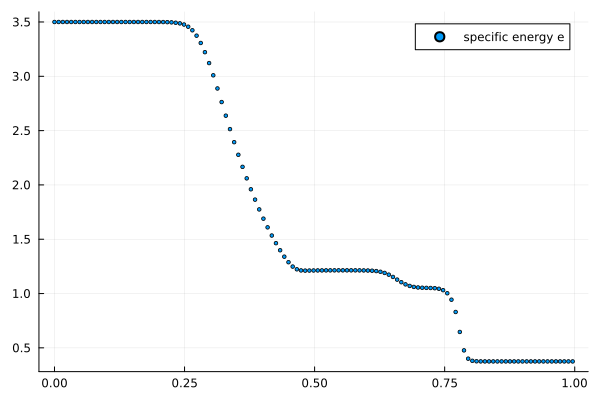

In [56]:
scatter(x[1:2:end], e_final[1:2:end], label="specific energy e", markersize=2)